# Adaptively Sampled MPC

This is a simple demonstration of an adaptively sampled region quadtree used to approximate the solutions to a model-predictive control problem. 

In [1]:
using Pkg
# pkg"activate ."

In [2]:
using RegionTrees
using StaticArrays: SVector
using Plots

┌ Info: Precompiling RegionTrees [dee08c22-ab7f-5625-9660-a9af2021b33f]
└ @ Base loading.jl:1317


In [45]:
# This module implements our MPC code, which consists of a 1-dimensional
# double-integrator system, forward-euler time-stepping dynamics, and a 
# 10 step prediction window. 

module mpc

using JuMP
using Ipopt
# using Gurobi
using StaticArrays
using Interpolations
using RegionTrees
import RegionTrees: AbstractRefinery, needs_refinement, refine_data

# const env = Gurobi.Env()

# Solve the MPC problem from a given initial position and velocity
function run_mpc(q0, v0)
    model = Model(Ipopt.Optimizer)  # GurobiSolver(env, OutputFlag=0)
    num_time_steps = 10
    dt = 0.1
    u_limit = 3
    C_q = 100
    c_vfinal = 100
    C_u = 1

    @variable model q[1:num_time_steps]
    @variable model v[1:num_time_steps]
    @variable model u[1:num_time_steps]

    @constraint model q[2:num_time_steps] .== q[1:num_time_steps-1] .+ v[1:num_time_steps-1] .* dt
    @constraint model v[2:num_time_steps] .== v[1:num_time_steps-1] .+ u[1:num_time_steps-1] .* dt
    @constraint model u .<= u_limit
    @constraint model u .>= -u_limit
    @constraint model q[1] == q0
    @constraint model v[1] == v0

    @objective model Min C_q * sum(q[i]^2 for i=1:num_time_steps) + c_vfinal * v[end]^2 + C_u * sum(u[i]^2 for i=1:num_time_steps)
    optimize!(model)

    value.(q), value.(v), value.(u)
end

# The MPCRefinery provides enough behavior to implement the 
# RegionTrees AdaptiveSampling interface, which lets us generate
# a quadtree of initial states and their corresponding MPC solutions.
struct MPCRefinery <: AbstractRefinery
end

function evaluate(cell, point)
    p = (point - cell.boundary.origin) ./ cell.boundary.widths
    cell.data(p[1] + 1, p[2] + 1)
end

# A cell in the quadtree needs refinement if its interpolated solution
# derived from its vertices is not a good fit for the true MPC solution
# at its center and the center of each of its faces
function needs_refinement(::MPCRefinery, cell)
    for x in body_and_face_centers(cell.boundary)
        value_interp = evaluate(cell, x)
        value_true = run_mpc(x[1], x[2])[3]
        if !isapprox(value_interp[1], value_true[1], rtol=1e-1, atol=1e-1)
            return true
        end
    end
    false
end

# The data element associated with a cell is a bilinear interpolation
# of the MPC function evaluated at the vertices of the cell.
function refine_data(r::MPCRefinery, cell::Cell, indices)
    refine_data(r, child_boundary(cell, indices))
end

function refine_data(::MPCRefinery, boundary::HyperRectangle)
    f = v -> run_mpc(v[1], v[2])[3]
    interpolate(f.(vertices(boundary)), BSpline(Linear()))
end

end

Main.mpc

In [46]:
# Simulate a given control function for the double integerator
# model.
function simulate(controller, q0, v0, dt, timespan)
    num_time_steps = timespan / dt
    qs = [q0]
    vs = [v0]
    ts = [0.0]
    q = q0
    v = v0
    for t in 0:dt:(timespan)
        u = controller(t, q, v)
        q += v * dt
        v += u * dt
        push!(qs, q)
        push!(vs, v)
        push!(ts, t)
    end
    ts, qs, vs
end
        

simulate (generic function with 1 method)

In [47]:
controller = (t, q, v) -> begin
    q, v, u = mpc.run_mpc(q, v)
    u[1]
end

#21 (generic function with 1 method)

In [48]:
t, q, v = simulate(controller, 10.0, 0.0, 0.1, 10)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

([0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [10.0, 10.0, 9.96999999970004, 9.909999999100119, 9.81999999820024, 9.699999997000406, 9.549999995500617, 9.369999993700874, 9.159999991601183, 8.919999989201544  …  8.597239350272846e-5, 5.362581536010068e-5, 2.8397909229847234e-5, 9.840908012319702e-6, -2.8884713881992606e-6, -1.081706641961334e-5, -1.500394219756951e-5, -1.6440589212467098e-5, -1.599250476782777e-5, -1.4372201482968778e-5], [0.0, -0.30000000299960844, -0.6000000059992039, -0.9000000089987841, -1.2000000119983485, -1.5000000149978956, -1.800000017997422, -2.1000000209969207, -2.400000023996384, -2.7000000269958027  …  -0.00032346578142627774, -0.00025227906130253445, -0.0001855700121752753, -0.00012729379400518962, -7.928595031414079e-5, -4.186875777956171e-5, -1.436647014897586e-5, 4.480844446393275e-6, 1.6203032848589938e-5, 2.237567469317579e-5])

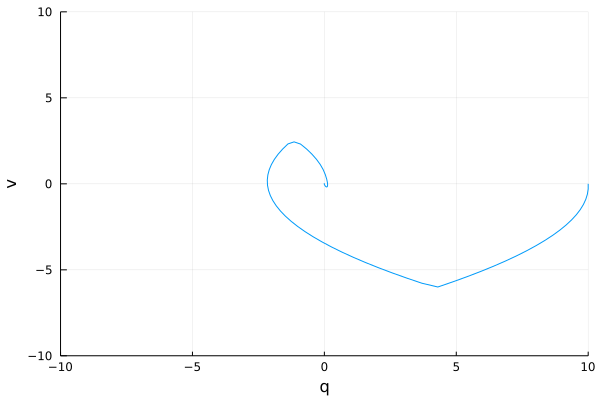

In [49]:
# State space portrait of the solution, starting from q=10, v=0
plot(q, v, xlim=(-10, 10), ylim=(-10, 10), xlabel="q", ylabel="v", legend=nothing)

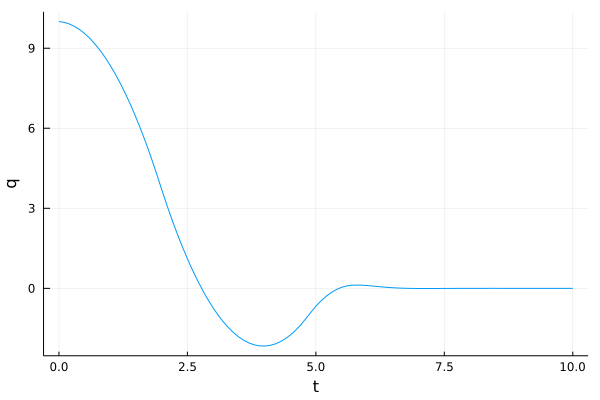

In [50]:
plot(t, q, xlabel="t", ylabel="q", legend=nothing)

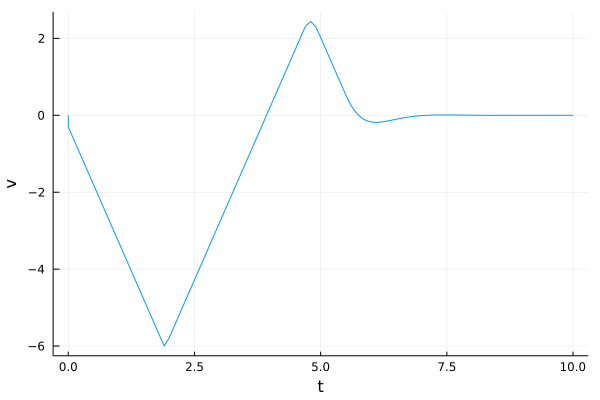

In [51]:
plot(t, v, xlabel="t", ylabel="v", legend=nothing)

# Approximating the solutions space
Now that we've written down and tested the true MPC solution, we can try to approximate it. The AdaptiveSampling() function will generate a quadtree by iteratively refining each cell in the space until the solutions to the MPC problem within that cell are well-approximated by the interpolation. 

In [52]:
boundary = RegionTrees.HyperRectangle(SVector(-10., -10), SVector(20., 20))
refinery = mpc.MPCRefinery()
root = RegionTrees.Cell(boundary, mpc.refine_data(refinery, boundary))
adaptivesampling!(root, refinery)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       56
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Cell: HyperRectangle{2, Float64}([-10.0, -10.0], [20.0, 20.0])

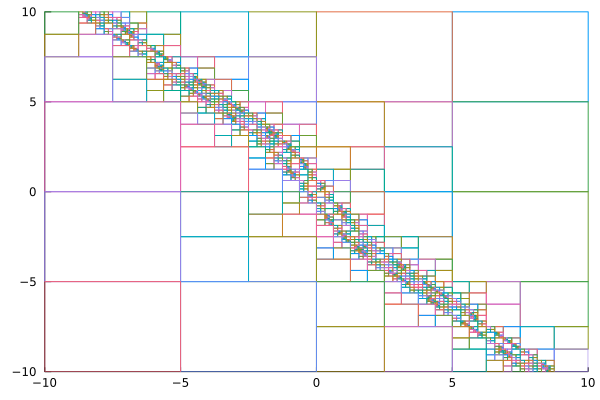

In [53]:
# Now we can plot each region in the quadtree. Note that we end up with
# a lot of detail along the switching surface from maximum acceleration
# to maximum deceleration
plt = plot(xlim=(-10, 10), ylim=(-10, 10), legend=nothing, grid=false)
for cell in RegionTrees.allleaves(root)
    v = hcat(collect(RegionTrees.vertices(cell.boundary))...)
    plot!(v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
end
plt

# Using the Approximate Solution
We can use the quadtree to produce an approximate controller for our system. Given the current state, we can look up the cell in the quadtree which encompasses that state, then use that cell's interpolation to find our control tape. 

In [54]:
approx_controller = (t, q, v) -> begin
    x = [q, v]
    leaf = RegionTrees.findleaf(root, x)
    u = mpc.evaluate(leaf, x)
    u[1]
end

#23 (generic function with 1 method)

In [55]:
t, q, v = simulate(approx_controller, 10.0, 0.0, 0.1, 10)

([0.0, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8  …  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0], [10.0, 10.0, 9.96999999970004, 9.90999999910012, 9.819999998200245, 9.699999997000418, 9.549999995500643, 9.36999999370093, 9.159999991601286, 8.919999989201726  …  9.992273413323964e-5, 6.221935382000836e-5, 3.2837480973900563e-5, 1.1244625393574895e-5, -3.5500465901535066e-6, -1.2748947505551736e-5, -1.759007120695472e-5, -1.9231078148039163e-5, -1.8681599632568377e-5, -1.6772128886438534e-5], [0.0, -0.30000000299960844, -0.6000000059991956, -0.9000000089987553, -1.2000000119982768, -1.5000000149977444, -1.8000000179971378, -2.100000020996432, -2.4000000239955965, -2.700000026994597  …  -0.0003770338031323128, -0.00029381872846107797, -0.00021592855580325666, -0.000147946719837284, -9.198900915398229e-5, -4.841123701402984e-5, -1.641006941084443e-5, 5.494785154707843e-6, 1.9094707461298444e-5, 2.6231440491169036e-5])

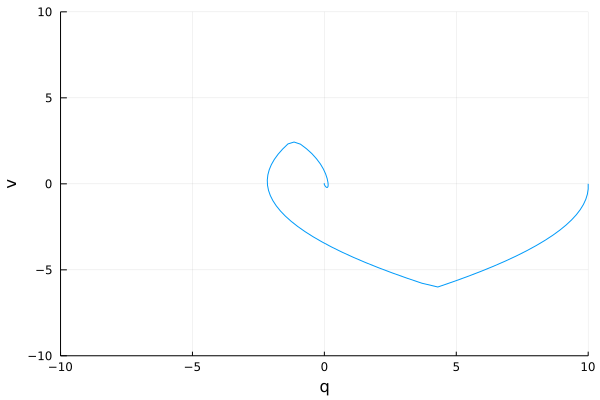

In [56]:
# The results are similar to, but not quite as good as, the 
# values obtained from the exact MPC solution. 
plot(q, v, xlim=(-10, 10), ylim=(-10, 10), xlabel="q", ylabel="v", legend=nothing)